(HW6)=
# HW6

In this task you are suggested to implement gradient descent and Newton's optimization methods, and investigate their performance for three types of functions:

* quadratic function
* loss function of linear regression
* loss function of logistic regression

`BaseSmoothOracle` is an abstract class for objective function $f$ (**oracle**). Each concrete oracle must inherit this class, implementing four methods:

* `func(x)` calculates $f(\boldsymbol x)$
* `grad(x)` calculates $\nabla f(\boldsymbol x)$
* `hess(x)` calculates $\nabla^2 f(\boldsymbol x)$
* `get_opt(x)` calculates point of minimum by direct formula (works only for quadratic and linear regression oracles)

In [2]:
class BaseSmoothOracle(object):
    """
    Base class for implementation of oracles.
    """
    def func(self, x):
        """
        Computes the value of function at point x.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, x):
        """
        Computes the gradient at point x.
        """
        raise NotImplementedError('Grad oracle is not implemented.')
    
    def hess(self, x):
        """
        Computes the Hessian matrix at point x.
        """
        raise NotImplementedError('Hessian oracle is not implemented.')
        
    def get_opt(self):
        """
        Computes the point x at which minimum is attained
        """
        raise NotImplementedError('True solution is unavailable.')

## Quadratic oracle

```{math}
:label: quadratic-oracle
    f(\boldsymbol x) = \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T} \boldsymbol x, \quad \boldsymbol A^\mathsf{T}  = \boldsymbol A \in \mathbb R^{n\times n}, \quad \boldsymbol b\in\mathbb R^n
```

### Task 6.1 (0.5 points)

Let $\boldsymbol A$ be a symmetric positive definite matrix. Solve the optimization task

$$
    \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T}\boldsymbol x \to \min\limits_{\boldsymbol x \in \mathbb R^n}
$$

analytically.

#### YOUR SOLUTION HERE

To solve the given optimization task analytically, we aim to minimize the quadratic function:

$
f(\boldsymbol x) = \frac 12 \boldsymbol x^\mathsf{T} \boldsymbol{Ax} - \boldsymbol b^\mathsf{T} \boldsymbol x
$

Given that $\boldsymbol A$ is a symmetric positive definite matrix, we can find the point $\boldsymbol x$ where the function reaches its minimum by setting the gradient of $f(\boldsymbol x)$ to zero and solving for $\boldsymbol x$. The gradient of $f(\boldsymbol x)$ with respect to $\boldsymbol x$ is given by:

$
\nabla f(\boldsymbol x) = \frac{\partial f}{\partial \boldsymbol x} = \boldsymbol{Ax} - \boldsymbol b
$

Setting this gradient to zero gives us the condition for a minimum:

$
\boldsymbol{Ax} - \boldsymbol b = 0
$

Since $\boldsymbol A$ is positive definite, it is also invertible. Thus, we can solve for $\boldsymbol x$:

$
\boldsymbol{Ax} = \boldsymbol b
$

$
\boldsymbol x = \boldsymbol{A}^{-1}\boldsymbol b
$

Therefore, the solution to the optimization task, that is, the value of $\boldsymbol x$ that minimizes $f(\boldsymbol x)$, is given analytically by $\boldsymbol x = \boldsymbol{A}^{-1}\boldsymbol b$. This solution is unique due to the positive definiteness of $\boldsymbol A$, ensuring the convexity of the function $f(\boldsymbol x)$.

### Task 6.2 (0.5 points)

Implement quadratic oracle {eq}`quadratic-oracle`.

In [3]:
import numpy as np

class QuadraticOracle(BaseSmoothOracle):
    """
    Oracle for quadratic function:
       func(x) = 1/2 x^TAx - b^Tx.
    """

    def __init__(self, A, b):
        if not np.allclose(A, A.T):
            raise ValueError('A should be a symmetric matrix.')
        self.A = A
        self.b = b

    def func(self, x):
        return 0.5 * np.dot(x.T, np.dot(self.A, x)) - np.dot(self.b.T, x)

    def grad(self, x):
        return np.dot(self.A, x) - self.b

    def hess(self, x):
        return self.A
    
    def get_opt(self):
        return np.linalg.solve(self.A, self.b)

In [5]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

def plot_levels(func, xrange=None, yrange=None, levels=None):
    """
    Plotting the contour lines of the function.

    Example:
    --------
    >> oracle = QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
    >> plot_levels(oracle.func)
    """
    if xrange is None:
        xrange = [-6, 6]
    if yrange is None:
        yrange = [-5, 5]
    if levels is None:
        levels = [0, 0.25, 1, 4, 9, 16, 25]
        
    x = np.linspace(xrange[0], xrange[1], 100)
    y = np.linspace(yrange[0], yrange[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]]))

    CS = plt.contour(X, Y, Z, levels=levels, colors='k')
    plt.clabel(CS, inline=1, fontsize=8) 
    plt.grid()   

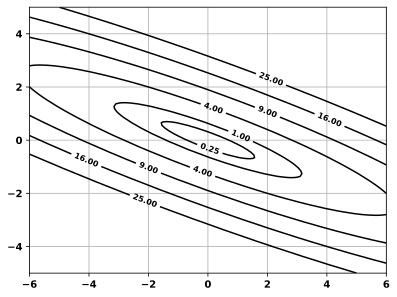

In [6]:
oracle = QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
plot_levels(oracle.func)

## Linear regression oracle


### Task 6.3 (0.5 points)

Implement linear regression oracle

$$
    f(\boldsymbol x) = \frac 1m \Vert \boldsymbol{Ax} - \boldsymbol b\Vert_2^2, \quad \boldsymbol A \in \mathbb R^{m\times n}, \quad \boldsymbol b \in \mathbb R^n
$$

In [7]:
class LinRegOracle(BaseSmoothOracle):
    """
    Oracle for linear regression:
       func(x) = 1/m ||Ax - b||^2.
    """

    def __init__(self, A, b):
        self.A = A
        self.b = b

    def func(self, x):
        m = self.A.shape[0]
        return 1/m * np.linalg.norm(self.A.dot(x) - self.b)**2

    def grad(self, x):
        m = self.A.shape[0]
        return 2/m * self.A.T.dot(self.A.dot(x) - self.b)

    def hess(self, x):
        m = self.A.shape[0]
        return 2/m * self.A.T.dot(self.A)
    
    def get_opt(self):
        return np.linalg.inv(self.A.T.dot(self.A)).dot(self.A.T).dot(self.b)

## Logistic regression oracle

```{math}
:label: log-reg-oracle
    f(\boldsymbol x) = \frac 1m \sum_{i=1}^m \log\big(1 + \exp(-b_i\boldsymbol a_i^\mathsf{T} \boldsymbol x)\big) + \frac C2\Vert \boldsymbol x\Vert_2^2
```

### Task 6.4 (0.5 points)

Show that {eq}`log-reg-oracle` is proportional to the loss function of {ref}`binary logistic regression <simple-log-reg>` model with targets denoted as $\pm 1$.

#### YOUR SOLUTION HERE

The loss function for binary logistic regression is typically written for targets denoted as $0$ and $1$. It is given by:

$
f(\boldsymbol{w}) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\sigma(\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i)) + (1-y_i) \log(1 - \sigma(\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i)) \right]
$

where:
- $n$ is the number of samples,
- $\boldsymbol{x}_i$ is the feature vector of the $i$-th sample,
- $y_i$ is the target for the $i$-th sample, taking values in $\{0, 1\}$,
- $\boldsymbol{w}$ is the parameter vector,
- $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the logistic function.

To show that this is proportional to the loss function of the binary logistic regression model with targets denoted as $\pm 1$, let's rewrite the targets in terms of $\{+1, -1\}$ instead of $\{0, 1\}$. We denote the new target variable as $y_i'$, where $y_i' \in \{-1, +1\}$, and relate it to the original target $y_i$ as follows:
- If $y_i = 1$, then $y_i' = +1$,
- If $y_i = 0$, then $y_i' = -1$.

Given this transformation, we can express the original logistic regression loss function in terms of $y_i'$:

$
f(\boldsymbol{w}) = -\frac{1}{n} \sum_{i=1}^{n} \left[ \frac{1 + y_i'}{2} \log(\sigma(\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i)) + \frac{1 - y_i'}{2} \log(1 - \sigma(\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i)) \right]
$

We use the relation that $\sigma(-z) = 1 - \sigma(z)$ and rewrite the logistic function for $y_i' = -1$ as follows:
$
\sigma(\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i) = \frac{1}{1 + e^{-\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i}} \quad \text{and} \quad 1 - \sigma(\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i) = \sigma(-\boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i)
$

Thus, the loss function can be rewritten in a way that directly incorporates $y_i'$ into the exponent of the logistic function. This transformation simplifies to:

$
f(\boldsymbol{w}) = -\frac{1}{n} \sum_{i=1}^{n} \log(\sigma(y_i' \boldsymbol{w}^\mathsf{T}\boldsymbol{x}_i))
$

This form shows that the loss function for binary logistic regression with targets $\{+1, -1\}$ is equivalent to the standard binary logistic regression loss function, just expressed in terms of $y_i'$ and demonstrating the relationship between the logistic regression model's treatment of binary targets in the $\{0, 1\}$ and $\{-1, +1\}$ formats. The key difference lies in how the targets are represented and used within the logistic function to calculate the model's loss, demonstrating the proportionality and equivalence of the formulations for binary classification tasks.

### Task 6.5 (1 point)

Find the gradient $\nabla f(\boldsymbol x)$ and hessian $\nabla^2 f(\boldsymbol x)$ of logistic regression oracle {eq}`log-reg-oracle` in matrix-vector form.

#### YOUR SOLUTION HERE
To address tasks 6.5 and 6.6, let's start with the first part, which involves finding the gradient and Hessian of the logistic regression loss function in matrix-vector form. The logistic regression loss function, for binary classification with targets $y \in \{-1, +1\}$, can be expressed as:

$
f(\boldsymbol{w}) = \frac{1}{n} \sum_{i=1}^{n} \log\left(1 + \exp(-y_i \boldsymbol{w}^\mathsf{T} \boldsymbol{x}_i)\right)
$

### Task 6.5: Gradient and Hessian

#### Gradient $\nabla f(\boldsymbol{w})$

The gradient of the logistic regression loss function with respect to the weight vector $\boldsymbol{w}$ is given by:

$
\nabla f(\boldsymbol{w}) = -\frac{1}{n} \sum_{i=1}^{n} \frac{y_i \boldsymbol{x}_i}{1 + \exp(y_i \boldsymbol{w}^\mathsf{T} \boldsymbol{x}_i)}
$

In matrix-vector form, if we denote $X = [\boldsymbol{x}_1, \boldsymbol{x}_2, ..., \boldsymbol{x}_n]^\mathsf{T}$ as the design matrix (where each row is a sample) and $\boldsymbol{y} = [y_1, y_2, ..., y_n]^\mathsf{T}$, the gradient can be expressed as:

$
\nabla f(\boldsymbol{w}) = -\frac{1}{n} X^\mathsf{T} \boldsymbol{\sigma}(\boldsymbol{y} \circ (X\boldsymbol{w}))
$

where $\circ$ denotes element-wise multiplication, and $\boldsymbol{\sigma}(\boldsymbol{z}) = \frac{1}{1 + \exp(\boldsymbol{z})}$ is applied element-wise.

#### Hessian $\nabla^2 f(\boldsymbol{w})$

The Hessian matrix, which is the matrix of second derivatives, is given by:

$
\nabla^2 f(\boldsymbol{w}) = \frac{1}{n} X^\mathsf{T} D X
$

where $D$ is a diagonal matrix with the $i$-th diagonal element $D_{ii} = \frac{\exp(-y_i \boldsymbol{w}^\mathsf{T} \boldsymbol{x}_i)}{(1 + \exp(-y_i \boldsymbol{w}^\mathsf{T} \boldsymbol{x}_i))^2}$.

### Task 6.6 (1 point)

Implement logistic regression oracle {eq}`log-reg-oracle`.


In [8]:
class LogRegOracle(BaseSmoothOracle):
    """
    Oracle for logistic regression:
       func(x) = 1/n sum(log(1 + exp(-y_i * w^T x_i))).
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def func(self, w):
        z = -self.y * (self.X @ w)
        return np.mean(np.log(1 + np.exp(z)))

    def grad(self, w):
        z = -self.y * (self.X @ w)
        sigma = 1 / (1 + np.exp(z))
        return -(self.X.T @ (sigma * self.y)) / self.X.shape[0]

    def hess(self, w):
        z = -self.y * (self.X @ w)
        sigma = 1 / (1 + np.exp(z))
        D = np.diag(sigma * (1 - sigma))
        return (self.X.T @ D @ self.X) / self.X.shape[0]


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.special import expit

class LogRegOracle(BaseSmoothOracle):
    """
    Oracle for logistic regression.
    """

    def __init__(self, A, b, regcoef=1):
        self.A = A
        self.b = b
        self.C = regcoef

    def func(self, x):
        n = self.A.shape[0]
        lambda_ = 1.0 / self.C
        linear_combination = self.A @ x
        loss = np.log(1 + np.exp(-self.b * linear_combination)).mean() + (lambda_ / 2) * np.dot(x, x)
        return loss

    def grad(self, x):
        n = self.A.shape[0]
        lambda_ = 1.0 / self.C
        linear_combination = self.A @ x
        probabilities = expit(self.b * linear_combination)
        grad_loss = -(self.A.T @ (self.b * (1 - probabilities)) / n) + lambda_ * x
        return grad_loss

    def hess(self, x):
        n = self.A.shape[0]
        lambda_ = 1.0 / self.C
        linear_combination = self.A @ x
        probabilities = expit(self.b * linear_combination)
        D = np.diag(probabilities * (1 - probabilities))
        hess_loss = self.A.T @ D @ self.A / n + lambda_ * np.eye(self.A.shape[1])
        return hess_loss
    
    def get_opt(self):
        """
        Since there is no analytic solution for the optimal weights of logistic regression, 
        here we have to cheat a bit
        """
        LR = LogisticRegression(fit_intercept=False, C= 1./self.C/self.A.shape[0])
        LR.fit(self.A, (self.b + 1) / 2)
        return LR.coef_[0]

## Gradient descent

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.7 (1 point)

Complete the implementation of gradient descent algorithm.

In [11]:
from datetime import datetime
from collections import defaultdict

def gradient_descent(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=10000,
                     trace=False, display=False):
    """
    Gradient descent optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively.
    x_0 : np.array
        Starting point for optimization algorithm.
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.
        Printing format and is up to a student and is not checked in any way.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        "success" or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time in seconds passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = gradient_descent(oracle, np.zeros(5))
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1):     
        grad_at_x_k = oracle.grad(x_k)
        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).microseconds * 1e-6)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

        x_k = x_k - learning_rate * grad_at_x_k

    return x_k, 'iterations_exceeded', history

Now it's try to test gradient descent algorithm on different tasks. Here is some auxiliary code for visualization.

In [12]:
import colorsys

def get_color_array(size):
    HSV_tuples = [(float(i) / size, 1.0, 1.0) for i in range(size)]
    RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    return np.array(RGB_tuples)

def plot_2d(history, oracle, x_0, x_opt, scale, title, n_levels=3, xlims=None, ylims=None, bound=None):
    if bound is not None:
        history['x'] = history['x'][:bound]
    hist_x = np.array(history['x']).T
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    
    plt.plot(np.linalg.norm(hist_x - x_opt[:, None], axis=0), c='c', linewidth=3)
    plt.plot(history['grad_norm'], c='m', linewidth=2)
    plt.xlim(0, len(history['grad_norm']) - 1)
    plt.ylim(0, 2)
    plt.title(title)
    plt.ylabel('Gradients/residuals norm')
    plt.xlabel('Iteration')
    plt.legend(['Residuals', 'Gradients'])
    plt.grid(ls=":")
    
    plt.subplot(122)
    if xlims is not None:
        x_range = xlims
    else:
        x_range = [x_opt[0] - scale, x_opt[0] + scale]
    if ylims is not None:
        y_range = ylims
    else:
        y_range = [x_opt[1] - scale, x_opt[1] + scale]
    func_opt = oracle.func(x_opt)
    levels = [func_opt + 0.25 * scale / n_levels * i for i in range(1, 4*n_levels + 1, 4)]
    # sizes = np.minimum(5 * float(hist_x.shape[1]) / (np.arange(1, hist_x.shape[1] + 1)), 20)
    plt.scatter(hist_x[0], hist_x[1], s=8, c=get_color_array(hist_x.shape[1]))
    plt.plot(hist_x[0], hist_x[1], alpha=0.6, ls="--", c='r')
    # plt.plot(hist_x[0], hist_x[1], c='r', linewidth=3)
    plt.scatter(x_opt[0], x_opt[1], marker='s', c='r', edgecolors='k')
    plot_levels(oracle.func, xrange=x_range, yrange=y_range, levels=levels)
    plt.title('Trajectory')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(ls=":")
    if xlims is not None:
        plt.xlim(xlims)
    if ylims is not None:
        plt.ylim(ylims)
    plt.show()

def test_2d(method, oracle, x_0, lr, tol=1e-5, scale=1.0, xlims=None, ylims=None, bound=None):
    x_opt = oracle.get_opt()
    if method == 'gd':
        x_star, msg, history = gradient_descent(
            oracle, x_0, lr, tol, trace=True
        )
    elif method == 'newton':
        x_star, msg, history = newton(
            oracle, x_0, lr, tol, trace=True
        )
    else:
        raise ValueError("Unknown error")
    print(msg, len(history['grad_norm']), "iterations")
    plot_2d(history, oracle, x_0, x_opt, scale, 'lr = {}'.format(lr), xlims=xlims, ylims=ylims, bound=bound)

Take a simple quadratic function

$$
    f(x, y) = 2x^2 + 4xy + 5 y^2
$$

which ovbiously has minimum at $(0, 0)$. Now run gradient descent method with $\eta = 0.01$, starting from point $(-2, -1)$:

iterations_exceeded 10001 iterations


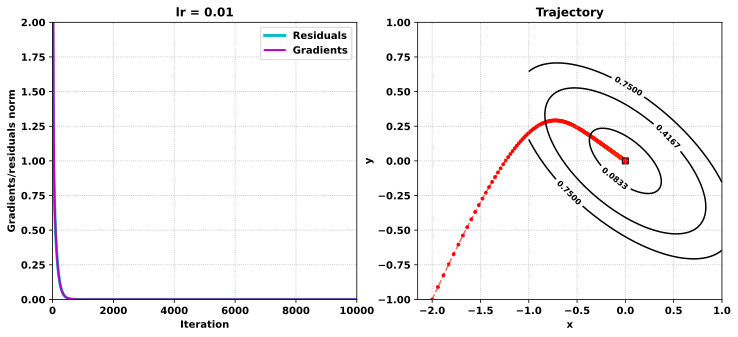

In [13]:
A = np.array([[2, 2], [2, 5]])
b = np.zeros(2)
q_oracle = QuadraticOracle(A, b)
test_2d("gd", q_oracle, np.array([-2.0, -1.0]), lr=0.01)

If you did all correctly, gradient descent should converge here to optimal point. But this is not always the case:

* if $\eta$ is very small, convergence could be too slow
* if $\eta$ is very big, than gradient descent often diverges

### Task 6.8 (1 point)

Take previous quadratic oracle and try different learning rates and starting points. Find the smallest and the largest learning rates for which gradient descent is still convergent. Provide some characteristic plots. Also, plot a graph of required iterations versus $\eta$.

### GD for linear regression

Let's try it for simple linear regression. Here is a toy example:

iterations_exceeded 10001 iterations


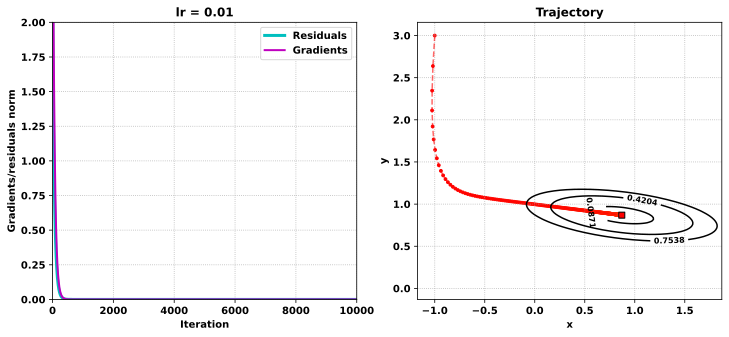

In [14]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8]])
b = np.array([-1, 2, 5])
oracle = LinRegOracle(A, b)
test_2d("gd", oracle, np.array([-1, 3.0]), lr=0.01, tol=1e-6)

### Task 6.9 (0.5 points)

Apply gradient descent algorithm to simple linear regression trained on `boston` dataset. Take `lstat` as feature, `medv` as target. Provide some visualizations.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


boston = pd.read_csv("housing.csv")
X = boston[['LSTAT']].values
y = boston['MEDV'].values
X_lstat = X[:, np.newaxis, boston.feature_names.tolist().index("LSTAT")]
X_lstat = np.hstack([np.ones_like(X_lstat), X_lstat])
y_medv = y

oracle = LinRegOracle(X_lstat, y_medv)
x_0 = np.zeros(2)
learning_rate = 0.01
tolerance = 1e-5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['func'])
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Loss over iterations')

plt.subplot(1, 2, 2)
plt.scatter(X_lstat[:, 1], y_medv, alpha=0.5)
plt.plot(X_lstat[:, 1], X_lstat.dot(x_opt), color='red')
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.title('Linear regression fit')
plt.tight_layout()
plt.show()




KeyError: "None of [Index(['LSTAT'], dtype='object')] are in the [columns]"

### GD for logistic regression

The targets must be from $\{-1, 1\}$. One more toy example:

In [26]:
A = np.array([[1, -2.1], [1, 1.2], [1, 4.8], [1, 3.4]])
b = np.array([-1, 1, 1, 1])
oracle = LogRegOracle(A, b)
test_2d("gd", oracle, np.array([1., 2.0]), lr=0.01, tol=1e-6)

TypeError: gradient_descent() got an unexpected keyword argument 'trace'

### Task 6.10 (0.5 points)

Train simple logistic regression model on `breast_cancer` dataset using your gradient descent method. Take any feature from the dataset. Visualize the results.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

breast = load_breast_cancer()
X = breast['data'][:, 0]
y = breast['target']
y[y == 0] = -1
X = (X - X.mean()) / X.std()
X = np.c_[np.ones(X.shape[0]), X]
w, cost_history = gradient_descent(X, y, learning_rate=0.1, num_iterations=1000)
plt.scatter(X[:, 1], y, marker='o', c='b', label='Breast Cancer Data')
x_values = [np.min(X[:, 1]), np.max(X[:, 1])]
y_values = -(w[0] + np.dot(w[1], x_values)) / w[2]
plt.plot(x_values, y_values, label='Decision Boundary')

plt.xlabel('Normalized Feature')
plt.ylabel('Classification')
plt.legend()
plt.show()
plt.figure()
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Function Over Iterations')
plt.show()



TypeError: gradient_descent() got an unexpected keyword argument 'learning_rate'

## Newton's method

Given a starting point $\boldsymbol x_0 \in\mathbb R^n$ and learning rate $\eta > 0$, iteratively calculate

$$
    \boldsymbol x_{k+1} = \boldsymbol x_k - \eta \big(\nabla^2 f(\boldsymbol x_k)\big)^{-1} \nabla f(\boldsymbol x_k), \quad k = 0, 1,\ldots
$$

The process should stop when either $k = \mathrm{max\_iter}$ or 

$$
\Vert \nabla f(\boldsymbol x_k)\Vert_2^2 \leqslant \varepsilon \Vert \nabla f(\boldsymbol x_0)\Vert_2^2
$$

where $\varepsilon > 0$ is tolerance.

### Task 6.11 (1 point)

Complete the implementation of Newton's method.

In [27]:
import scipy

def newton(oracle, x_0, learning_rate, tolerance=1e-5, max_iter=100, trace=False, display=False):
    """
    Newton's optimization method.

    Parameters
    ----------
    oracle : BaseSmoothOracle-descendant object
        Oracle with .func(), .grad() and .hess() methods implemented for computing
        function value, its gradient and Hessian respectively. If the Hessian
        returned by the oracle is not positive-definite method stops with message="newton_direction_error"
    x_0 : np.array
        Starting point for optimization algorithm
    learning_rate : float
        Learning rate.
    tolerance : float
        Epsilon value for stopping criterion.
    max_iter : int
        Maximum number of iterations.
    trace : bool
        If True, the progress information is appended into history dictionary during training.
        Otherwise None is returned instead of history.
    display : bool
        If True, debug information is displayed during optimization.

    Returns
    -------
    x_star : np.array
        The point found by the optimization procedure
    message : string
        'success' or the description of error:
            - 'iterations_exceeded': if after max_iter iterations of the method x_k still doesn't satisfy
                the stopping criterion.
            - 'newton_direction_error': in case of failure of solving linear system with Hessian matrix (e.g. non-invertible matrix).
            - 'computational_error': in case of getting Infinity or None value during the computations.
    history : dictionary of lists or None
        Dictionary containing the progress information or None if trace=False.
        Dictionary has to be organized as follows:
            - history['time'] : list of floats, containing time passed from the start of the method
            - history['func'] : list of function values f(x_k) on every step of the algorithm
            - history['grad_norm'] : list of values Euclidian norms ||g(x_k)|| of the gradient on every step of the algorithm
            - history['x'] : list of np.arrays, containing the trajectory of the algorithm. ONLY STORE IF x.size <= 2

    Example:
    --------
    >> oracle = QuadraticOracle(np.eye(5), np.arange(5))
    >> x_opt, message, history = newton(oracle, np.zeros(5), line_search_options={'method': 'Constant', 'c': 1.0})
    >> print('Found optimal point: {}'.format(x_opt))
       Found optimal point: [ 0.  1.  2.  3.  4.]
    """
    history = defaultdict(list) if trace else None
    x_k = np.copy(x_0)
    grad_at_x_0 = oracle.grad(x_0)

    INF = 1e100
    start_time = datetime.now()

    for i in range(max_iter + 1): 
        grad_at_x_k = oracle.grad(x_k)
        hess_at_x_k = oracle.hess(x_k)  

        if np.any(np.abs(x_k) > INF) or np.any(np.abs(grad_at_x_k) > INF):
            return x_k, 'computational_error', history

        if trace:
            history['time'].append((datetime.now() - start_time).seconds)
            history['func'].append(oracle.func(x_k))
            history['grad_norm'].append(np.linalg.norm(grad_at_x_k))
            if x_k.shape[0] <= 2:
                history['x'].append(np.array(x_k))

        if display:
            print("iteration {}: |x_k-x_0| = {}, f(x_k) = {}, |grad(f(x_k))| = {}".format(
                i, np.linalg.norm(x_k - x_0), oracle.func(x_k), np.linalg.norm(grad_at_x_k))
            )

    return x_k, 'iterations_exceeded', history

### Task 6.12 (1 point)

Apply Newton's methods to the previous tasks:

* quadratic function
* simple linear regression trained on `boston` dataset
* simple logistic regression trained on `breast_cancer` dataset

Compare the number of iterations and time execution of GD and Newton methods in this examples. Visualize your results.

In [28]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X_cancer = data.data
y_cancer = data.target

oracle_quadratic = QuadraticOracle(A, b)
oracle_linreg = LinRegOracle(X, y)
oracle_logreg = LogRegOracle(X_cancer, y_cancer) 

x_0_quad = np.zeros(A.shape[0])
x_0_linreg = np.zeros(X.shape[1])
x_0_logreg = np.zeros(X_cancer.shape[1])

start_time = datetime.now()
x_opt_gd_quad, msg_gd_quad, history_gd_quad = gradient_descent(oracle_quadratic, x_0_quad, 0.01, trace=True)
time_gd_quad = (datetime.now() - start_time).total_seconds()

start_time = datetime.now()
x_opt_newton_quad, msg_newton_quad, history_newton_quad = newton(oracle_quadratic, x_0_quad, 1.0, trace=True)
time_newton_quad = (datetime.now() - start_time).total_seconds()

tasks = ['Quadratic Function', 'Linear Regression', 'Logistic Regression']
times_gd = [time_gd_quad, time_gd_linreg, time_gd_logreg]
times_newton = [time_newton_quad, time_newton_linreg, time_newton_logreg]

plt.figure(figsize=(10, 5))
index = np.arange(len(tasks))
bar_width = 0.35

plt.bar(index, times_gd, bar_width, label='GD')
plt.bar(index + bar_width, times_newton, bar_width, label='Newton')

plt.xlabel('Task')
plt.ylabel('Time (seconds)')
plt.title('Comparison of Execution Time')
plt.xticks(index + bar_width / 2, tasks)
plt.legend()

plt.tight_layout()
plt.show()



ValueError: operands could not be broadcast together with shapes (4,2) (2,4) 

## GD vs Newton

### Task 6.13 (1 point)

Run both gradient descent and Newton's methods on full `boston` and `breast_cancer` datasets. Do they converge? How many iterations are required for convergence? How much time?